# Polygenic Risk Score Analysis on Height GWAS data

Here we show an example of our [LDpred2 pipeline](https://github.com/cumc/bioworkflows/blob/master/ldpred/ldpred.ipynb) for height PRS on [an example public data-set](https://drive.google.com/file/d/1x_G0Gxk9jFMY-PMqwtg6-vdEyUPp5p5u/view) from github user [@choishingwan](https://github.com/choishingwan).

## Data used

### Reference panel

Obtained via `download_1000G()` in `bigsnpr`. 

We extracted unrelated European individuals (~500  samples) and ~1.7M SNPs in common with either HapMap3 or the UK Biobank. Classification of European population can be found at [IGSR](https://www.internationalgenome.org/category/population/). European individuals ID are from [IGSR data portal](https://www.internationalgenome.org/data-portal/sample).

### GWAS summary statistics data

`Height.QC.gz`, from public data-set provided by github user [@choishingwan](https://github.com/choishingwan), of height GWAS in European samples.

### Target test data

`EUR.height`, `EUR.cov`, and `EUR.eigenvec` contain phenotypes, covariates and genotype principle components of samples.

## PRS Models applied

Auto model runs the algorithm for 30 different $p$ (the proportion of causal variants) values range from 10e-4 to 0.9, and heritability $h^2$ from LD score regression as initial value.

Grid model tries a grid of parameters $p$, ranges from 0 to 1 and three $h^2$ which are 0.7/1/1.4 times of initial $h^2$ estimated by LD score regression.

## Data preparation

Please download the [GWAS data](https://drive.google.com/file/d/1x_G0Gxk9jFMY-PMqwtg6-vdEyUPp5p5u/view) and [pipeline script](https://github.com/cumc/bioworkflows/blob/master/ldpred/ldpred.ipynb) to your computer. We have pre-downloaded and extracted the European genotypes from 1000 Genomes. We have preprocessed the GWAS data as follows, to fit in our pipeline.

In [16]:
%cd ~/Downloads/tutorial

/home/gw/Downloads/tutorial

### Summary statistics formatting

In [2]:
sumstats <- bigreadr::fread2("GWAS_data/Height.QC.gz") 
# LDpred2 require the header to follow the exact naming
names(sumstats) <-
    c("chr",
    "pos",
    "rsid",
    "a1",
    "a0",
    "n_eff",
    "beta_se",
    "p",
    "OR",
    "INFO",
    "MAF")
# Transform the OR into log(OR)
sumstats$beta <- log(sumstats$OR)

In [3]:
saveRDS(sumstats, "GWAS_data/Height.QC.rds")

### Phenotype and covariates formatting

In [35]:
options(stringsAsFactors=F)
fam = read.table("GWAS_data/EUR.QC.fam", header=F)
colnames(fam) = c("FID", "IID", "PID", "MID", "S", "D")
pheno = read.table("GWAS_data/EUR.height", header=T)
covar = read.table("GWAS_data/EUR.cov", header=T)
pcs = read.table("GWAS_data/EUR.eigenvec", header=F)
colnames(pcs) = c("FID", "IID", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6")

In [36]:
require(dplyr)
pheno_out = left_join(fam, pheno, by = c("FID", "IID"))
pheno_out = left_join(pheno_out, covar, by = c("FID", "IID"))
pheno_out = left_join(pheno_out, pcs, by = c("FID", "IID"))

In [37]:
names(pheno_out)

[1] "FID"    "IID"    "PID"    "MID"    "S"      "D"      "Height" "Sex"   
 [9] "PC1"    "PC2"    "PC3"    "PC4"    "PC5"    "PC6"

In [44]:
write.table(pheno_out[, "Height"], "GWAS_data/EUR.height.matched.txt", col.names="Height",row.names=F)
write.table(pheno_out[, c("Sex",'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6')], "GWAS_data/EUR.cov.matched.txt", col.names=T,row.names=F)

The directory should have the following:

In [4]:
tree

.
├── 1000G.EUR
│   ├── 1000G.EUR.bed
│   ├── 1000G.EUR.bim
│   └── 1000G.EUR.fam
├── 1000G.EUR...bed
├── 1000G.EUR...bim
├── 1000G.EUR...fam
├── 1000G.EUR...log
├── 1000G.EUR...stdout
├── GWAS_data
│   ├── EUR.cov
│   ├── EUR.eigenvec
│   ├── EUR.height
│   ├── EUR.QC.bed
│   ├── EUR.QC.bim
│   ├── EUR.QC.fam
│   ├── Height.QC.gz
│   └── Height.QC.rds
└── ldpred.ipynb

2 directories, 17 files


## Analysis of height GWAS data

We set the work directory to `height_results` folder (to be created by the workflow). This will also be used as part of the filenames in the outputs to identify this analysis.

In [7]:
work_dir="height_results"

### Step 1: QC on reference panel

Here we assume the GWAS genotype data `EUR.*` has already been QC-ed. We perform here QC for reference panel,

In [8]:
sos run ldpred.ipynb snp_qc \
    --cwd $work_dir \
    --genoFiles 1000G.EUR/1000G.EUR.bed

INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /home/gw/Downloads/tutorial/height_results/1000G.EUR.height_results.bed
INFO: Workflow snp_qc (ID=w015cfd3cc381496b) is executed successfully with 1 completed step.


### Step 2: Intersect SNPs among summary stats, reference panel and target data

SNPs shared between summary statistics, reference panels and target genotype data (for which PRS will be computed) are extracted. 

In [9]:
sos run ldpred.ipynb snp_intersect \
    --cwd $work_dir \
    --ss GWAS_data/Height.QC.rds \
    --genoFiles $work_dir/1000G.EUR.$work_dir.bed GWAS_data/EUR.QC.bed

INFO: Running snp_intersect_1: SNP intersect of summary stats and genotype data
INFO: snp_intersect_1 is completed.
INFO: snp_intersect_1 output:   /home/gw/Downloads/tutorial/height_results/Height.QC.intersect.rds /home/gw/Downloads/tutorial/height_results/Height.QC.intersect.snplist
INFO: Running snp_intersect_2: 
INFO: snp_intersect_2 is completed (pending nested workflow).
INFO: Running preprocess_1: Filter SNPs and select individuals
INFO: preprocess_1 (index=1) is completed.
INFO: preprocess_1 (index=0) is completed.
INFO: preprocess_1 output:   /home/gw/Downloads/tutorial/height_results/1000G.EUR.height_results.snp_intersect.extracted.bed /home/gw/Downloads/tutorial/height_results/EUR.QC.snp_intersect.extracted.bed in 2 groups
INFO: Running convert PLNIK to bigsnpr format with missing data mean imputed: 
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=0) is completed.
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=1) is co

In [10]:
cat $work_dir/Height.QC.intersect.stdout

[1] "There are 400400 shared SNPs."


### Step 3: Harmonize alleles for shared SNPs

To handle major/minor allele, strand flips and consequently possible flips in sign for summary statistics.

In [11]:
sos run ldpred.ipynb snp_match \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss GWAS_data/Height.QC.rds

INFO: Running snp_match: 
INFO: snp_match is completed.
INFO: snp_match output:   /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.rds /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.snplist
INFO: Workflow snp_match (ID=waa8f5f3cb5665126) is executed successfully with 1 completed step.


### Step 4: Summary statistics quality control (optional)

Please refer to documentation in the pipeline notebook [`ldpred.ipynb`](https://github.com/cumc/bioworkflows/blob/master/ldpred/ldpred.ipynb) for an explanation of summary statistics QC.

In [12]:
sos run ldpred.ipynb sumstats_qc \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --sdy 1

INFO: Running sumstats_qc: 
INFO: sumstats_qc is completed.
INFO: sumstats_qc output:   /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.qc.png /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.qc.snplist... (3 items)
INFO: Workflow sumstats_qc (ID=wdbbf3e7458e2f8a0) is executed successfully with 1 completed step.


> height_results/Height.QC.snp_matched.qc.png (68.9 KiB):

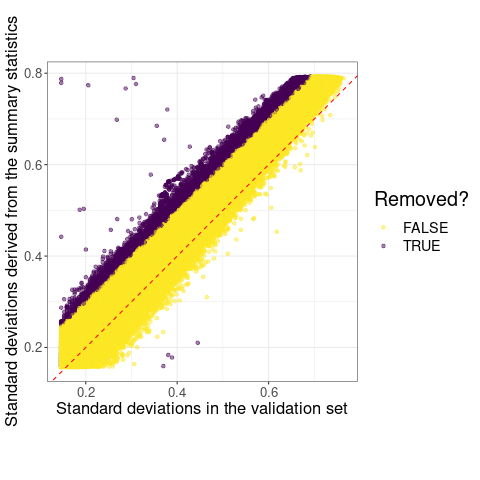

In [13]:
%preview height_results/Height.QC.snp_matched.qc.png

### Step 5: Calculate LD matrix and fit LDSC model

As an illustration, hereafter all analysis are performed on both summary statistics before and after QC in Step 4.

In [15]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.ld.rds
INFO: Workflow ldsc (ID=we9a3f5af1a3a1a9c) is executed successfully with 1 completed step.


In [17]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.qc.ld.rds
INFO: Workflow ldsc (ID=wbacc9e382c830fa4) is executed successfully with 1 completed step.


### Step 6: Estimate posterior effect sizes and PRS

For QC-ed data, we perform 3 PRS models implemented in `ldpred2`.

In [20]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --target-geno $work_dir/EUR.QC.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.qc.ld.rds

INFO: Running inf_prs: 
INFO: inf_prs is completed (pending nested workflow).
INFO: Running prs_core: 
INFO: prs_core is completed.
INFO: prs_core output:   /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.qc.inf_prs.rds
INFO: inf_prs output:   /home/gw/Downloads/tutorial/height_results/Height.QC.snp_matched.qc.inf_prs.rds
INFO: Workflow inf_prs (ID=w3fac9d56baf0b108) is executed successfully with 2 completed steps.


In [21]:
cat $work_dir/Height.QC.snp_matched.qc.inf_prs.stdout

[1] "378890 SNPs are used for PRS calculations"


In [ ]:
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --target-geno $work_dir/EUR.QC.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.qc.ld.rds

INFO: Running auto_prs: 
INFO: auto_prs is completed (pending nested workflow).
INFO: Running prs_core: 


In [ ]:
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --target-geno $work_dir/EUR.QC.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.qc.ld.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

For original data,

In [ ]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --target-geno $work_dir/EUR.QC.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.ld.rds

In [ ]:
cat $work_dir/Height.QC.snp_matched.inf_prs.stdout

In [ ]:
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --target-geno $work_dir/EUR.QC.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.ld.rds

In [ ]:
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --target-geno $work_dir/EUR.QC.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.ld.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

**For `grid` model, in practice we should use another subset of individuals to train the model, independent from the subset to make PRS predictions. Here we use the same target genotype data only to illustrate the workflow.**

### Step 7: predict phenotypes

Baseline model: Trait ~ Sex + PCs

In [4]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.baseline.rds
INFO: Workflow pred_eval (ID=w2415704657bde76b) is executed successfully with 1 completed step.


In [5]:
res = readRDS("height_results/UKB.hdl.baseline.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7973 -0.6148 -0.0072  0.5943  3.2185 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.083025   0.177526  -0.468   0.6401    
AGE          0.007225   0.003028   2.386   0.0171 *  
SEX         -0.857958   0.046395 -18.492   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9257 on 1597 degrees of freedom
Multiple R-squared:  0.177,	Adjusted R-squared:  0.176 
F-statistic: 171.7 on 2 and 1597 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model,0.17597,0.95412


Inf/grid/auto model: Traits ~ Sex + Age + PRS

In [38]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.qc.inf_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.inf_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval (index=0) is ignored due to saved signature
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.inf_prs.rds
INFO: Workflow pred_eval (ID=we0f848b067c83826) is ignored with 1 ignored step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.inf_prs.rds
INFO: Workflow pred_eval (ID=wbb35457749543c1e) is executed successfully with 1 completed step.


In [39]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9274 -0.5944  0.0028  0.5898  3.5610 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.515490   0.182145  -2.830  0.00471 ** 
AGE          0.006138   0.002972   2.065  0.03907 *  
SEX         -0.857887   0.045493 -18.858  < 2e-16 ***
PRS         -0.664444   0.082400  -8.064 1.44e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9076 on 1596 degrees of freedom
Multiple R-squared:  0.2092,	Adjusted R-squared:  0.2077 
F-statistic: 140.8 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.20773,0.91876


In [40]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9751 -0.5807 -0.0083  0.5798  3.7434 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.433701   0.173408  -2.501   0.0125 *  
AGE          0.006043   0.002913   2.074   0.0382 *  
SEX         -0.857926   0.044609 -19.232   <2e-16 ***
PRS         -0.787219   0.068654 -11.466   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.89 on 1596 degrees of freedom
Multiple R-squared:  0.2396,	Adjusted R-squared:  0.2382 
F-statistic: 167.7 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.23821,0.89215


In [41]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.qc.grid_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.grid_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.grid_prs.rds
INFO: Workflow pred_eval (ID=w572e9a7b247e7f40) is executed successfully with 1 completed step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.grid_prs.rds
INFO: Workflow pred_eval (ID=w91862006b36b43f9) is executed successfully with 1 completed step.


In [42]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.grid_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9274 -0.6107 -0.0004  0.5825  3.7149 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.316030   0.172306  -1.834   0.0668 .  
AGE          0.006228   0.002919   2.134   0.0330 *  
SEX         -0.852849   0.044702 -19.079   <2e-16 ***
PRS         -0.802795   0.071950 -11.158   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8918 on 1596 degrees of freedom
Multiple R-squared:  0.2366,	Adjusted R-squared:  0.2351 
F-statistic: 164.8 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.grid_prs,0.23512,0.89653


In [43]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.grid_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0014 -0.5953 -0.0181  0.5609  3.8511 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.367020   0.169185  -2.169   0.0302 *  
AGE          0.006092   0.002865   2.126   0.0337 *  
SEX         -0.847968   0.043891 -19.320   <2e-16 ***
PRS         -1.046833   0.076154 -13.746   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8756 on 1596 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2627 
F-statistic: 190.9 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.grid_prs,0.26274,0.86741


In [44]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.qc.auto_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.auto_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.auto_prs.rds
INFO: Workflow pred_eval (ID=w9bf9aef80a3a5b7d) is executed successfully with 1 completed step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.auto_prs.rds
INFO: Workflow pred_eval (ID=w099507f42af13c80) is executed successfully with 1 completed step.


In [45]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.auto_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9925 -0.6067  0.0001  0.5854  3.5452 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.491939   0.180478  -2.726  0.00649 ** 
AGE          0.006317   0.002966   2.130  0.03336 *  
SEX         -0.853595   0.045421 -18.793  < 2e-16 ***
PRS         -1.333720   0.158835  -8.397  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9061 on 1596 degrees of freedom
Multiple R-squared:  0.2118,	Adjusted R-squared:  0.2103 
F-statistic:   143 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.auto_prs,0.21034,0.91589


In [46]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.auto_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0331 -0.5738 -0.0088  0.5593  3.7989 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.405491   0.172225  -2.354   0.0187 *  
AGE          0.006289   0.002903   2.167   0.0304 *  
SEX         -0.851866   0.044459 -19.161   <2e-16 ***
PRS         -1.332495   0.111293 -11.973   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.887 on 1596 degrees of freedom
Multiple R-squared:  0.2448,	Adjusted R-squared:  0.2434 
F-statistic: 172.5 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.auto_prs,0.24341,0.88515


## Results summary

Following table shows adjusted R squared of HDL prediction model for original betas and posterior betas. QC is quality control in step 4.

Compared to baseline model, higher r-squared in ldpred model implies PRS explains part of the variation of HDL in train dataset (n=1600). 

Posterior betas have greater R squared compared to originial betas which implies PRS derived from posterior betas can explain much variance of HDL compared to PRS derived from original betas.

Among Inf, Grid and Auto, phynotype model with PRS derived using Grid model has the largest R squared which implies that Ldpred-grid model can find a hyper-parameter combination in prior distribution so that the PRS derived based on this prior distribution can explain much variance of HDL.

|   Betas   | QC? |   # of SNPs  |   Baseline  |   Inf   |   Grid  |   Auto |
|:---------:|:---:|:------------:|:-------:|:-------:|:-------:|:-------:|
|  Original | Yes | 232,552 | 0.176 | 0.20773 | 0.23512  | 0.21034 |
|  Original |  No | 384,249 | 0.176 | 0.23821 |    0.26274  |    0.24341   |
| Posterior | Yes | 20,823 | 0.176 |  0.23703 | 0.25036 | 0.22918 |
| Posterior |  No |  384,249  |  0.176  |  0.27772 |    0.28625    |    0.22346   |